# TLDR: 
Use this notebook to download a Canopy Height Map as a geotiff for a user define polygon from the global dataset (https://registry.opendata.aws/dataforgood-fb-forests/, browsable here: https://meta-forest-monitoring-okw37.projects.earthengine.app/view/canopyheight). 


# Details: 

- Given a polygon (in the form of a geojson), this notebook will go through the process of downloading the appropriate geotiffs from AWS S3, along with the associated metadata files and cloud masks.
- The geotiffs on S3 are stored as web mercator tiles, and this notebook will merge those tiled geotiffs (if necessary for the given polygon) and then crop down to the region specfied by the input polygon.
- The final product is a geotiff that has been cropped and cloud masked as needed, given potential clouds in the input imagery.

# Reference 
https://sustainability.atmeta.com/blog/2024/04/22/using-artificial-intelligence-to-map-the-earths-forests/

In [59]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.merge import merge
import rasterio.mask
from PIL import Image
from pyproj import Transformer
from shapely.geometry import box
from shapely.geometry import box, GeometryCollection, MultiPolygon, polygon, shape
import json
import rioxarray as rxr
from rasterio.warp import Resampling

In [54]:
transformer

<Concatenated Operation Transformer: pipeline>
Description: axis order change (2D) + Inverse of NAD83 to WGS 84 (1) + Conus Albers
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. United States (USA) - Alabama; Alaska (mainland); Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-172.54, 23.81, -47.74, 86.46)

In [38]:
print(source_crs)

EPSG:5070


In [81]:
CRS = "EPSG:4326"
# clip_bbox = [-74.5, 39, -73, 41]
COORDS = (-74.01, 40.75, -73.86, 40.88)

readfile = "../data_pipeline/data/raw/nlcd_tcc_CONUS_2021_v2021-4/nlcd_tcc_conus_2021_v2021-4.tif"
savefile = "../data_pipeline/data/tiff/1x1/tree_canopy_res30.tif"

with rasterio.open(readfile) as src:
    source_crs = src.crs  # Get the source CRS of the TIFF file
    
# Create a transformer to convert coordinates from target CRS to source CRS
transformer = Transformer.from_crs(CRS, source_crs, always_xy=True, allow_ballpark=False)

# Transform the bounding box coordinates
xmin_source, ymin_source = transformer.transform(COORDS[0], COORDS[1])
xmax_source, ymax_source = transformer.transform(COORDS[2], COORDS[3])

# Define the bounding box in the source CRS
bbox_source = (xmin_source, ymin_source, xmax_source, ymax_source)


# Step 1: Open the TIFF file using rioxarray
rds = rxr.open_rasterio(readfile, masked=True)
rds_cropped = rds.rio.clip_box(*bbox_source)

rds_reprojected = rds_cropped.rio.reproject(CRS, resolution=0.00025, resampling=Resampling.bilinear)
# rds_reprojected = rds_reprojected.rio.clip_box(*COORDS)

# Step 4: Save the cropped and reprojected raster to a new file
# rds_reprojected.rio.to_raster(savefile)

In [90]:
rds_reprojected.dtype

dtype('float32')

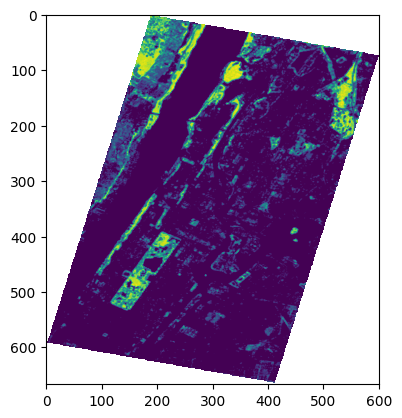

In [63]:
plt.imshow(rds_reprojected.data[0])

In [128]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "../data_pipeline/data/tiff/3x3/3x3_std_dev_canopy_height_res10.tif"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    count = dst
    res = dst.res
    desc = dst.descriptions
    data = dst.read(1)
    data2 = dst.read(2)
    crs = dst.crs
    meta = dst.meta
    bounds = dst.bounds
    transform = dst.transform
    
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# band_lst = [street_width, traffic_dir, street_lane, orientation]
# band_name = ['width', 'traffic', 'lane', 'orientation']
# # Flatten the axes for easier indexing
# axes = axes.flatten()

# for i in range(len(band_lst)):
#     im = axes[i].imshow(band_lst[i], cmap='viridis')
#     axes[i].set_title(band_name[i])
#     fig.colorbar(im, ax=axes[i])

# plt.tight_layout()
# plt.show()


In [131]:
desc

('canopy_heigth_res10_std_dev_3x3', 'canopy_heigth_count_res10_std_dev_3x3')

In [127]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 1785,
 'height': 1547,
 'count': 2,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(8.404159448270162e-05, 0.0, -74.01000022888184,
        0.0, -8.404078960993652e-05, 40.880002778522254)}

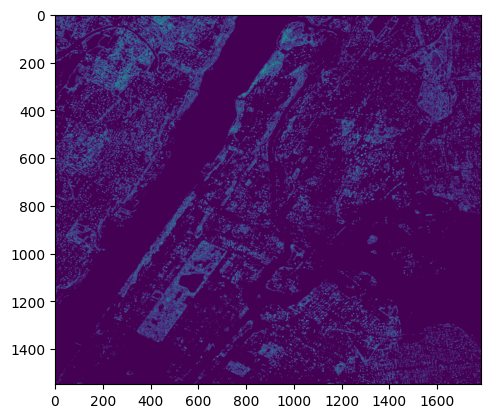

In [130]:
plt.imshow(data)

In [96]:
res[0] / (30 / 111035)

0.034563479045163915

In [22]:
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
tiff_path = "data/032010110_cropped.tif"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as dst:
    data = dst.read(1)
    crs = dst.crs
    meta = dst.meta
    bounds = dst.bounds

In [9]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16064,
 'height': 13922,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(9.338536239518326e-06, 0.0, -74.01000022888184,
        0.0, -9.338536239518158e-06, 40.880002778522254)}

In [75]:
np.mean(data)

1.3297288373084304

In [76]:
np.min(data)

0

In [77]:
np.max(data)

43

In [79]:
np.percentile(data, 5)

0.0

In [80]:
np.percentile(data, 95)

11.0

In [78]:
np.std(data)

3.7796186629481294

In [67]:
plt.hist(data)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001F9CCA3EFC0> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <function CachingFileManager.__del__ at 0x000001F98255D580>
Traceback (most recent call last):
  File "d:\Data\ey_challenge\geo\Lib\site-packages\xarray\backends\file_manager.py", line 244, in __del__
    ref_count = self._ref_counter.decrement(self._key)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Data\ey_challenge\geo\Lib\site-packages\xarray\backends\file_manager.py", line 312, in decrement
    def decrement(self, name):

KeyboardInterrupt: 


KeyboardInterrupt: 

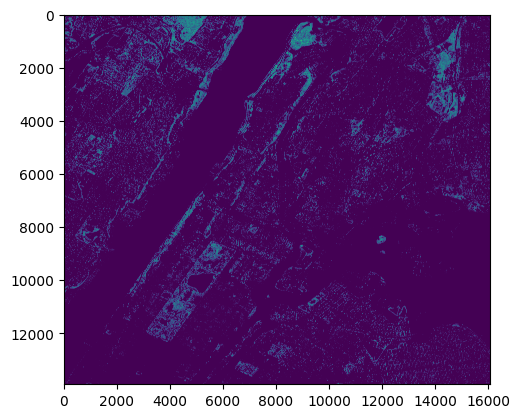

In [12]:
plt.imshow(data)

In [2]:
# a few raster functions

def merge_rasters(files, outfile: str = "test.tif") -> None:
    """
    Merge a list of geotiffs into one file
    """
    src_files_to_mosaic = []
    for fp in files:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    crs = src.crs
    out_meta = src.meta.copy()
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Update the metadata
    out_meta.update(
        {
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans,
            "crs": crs,
        }
    )

    with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE", BIGTIFF='YES') as dest:
        dest.write(mosaic)

def crop_raster(rasterfile: str, aoifile:str, outfile: str = "test.tif", nodata=255):
    gdf_aoi=gp.read_file(aoifile)
    with rasterio.open(rasterfile) as src:
            out_meta = src.meta.copy()
            if not src.crs == gdf_aoi.crs:
                gdf_aoi=gdf_aoi.to_crs(src.crs)
            aoi=gdf_aoi.iloc[0].geometry
            im, trans = rasterio.mask.mask(
                src, [aoi], crop=True, nodata=nodata, all_touched=True
            )
            # Update the metadata
            out_meta.update(
            {
                "driver": "GTiff",
                "height": im.shape[1],
                "width": im.shape[2],
                "transform": trans,
                "crs": src.crs,
                "nodata": nodata,
            }
            )
    with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE", BIGTIFF='YES') as dest:
        dest.write(im)

def enforce_mask(file, outfile=None, nodata=255):
    if not outfile:
        outfile=file.replace('.tif', 'masked.tif')
    with rasterio.open(file) as src:
        mask=src.read_masks()
        data=src.read()
        #nodata has been assigned as 255 in the S3 .msk files
        data[mask==255]=nodata
        out_meta=src.meta
        out_meta.update(
            {"nodata":nodata}
        )
        with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE") as dest:
            dest.write(data)

In [3]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [4]:
bucket='dataforgood-fb-data'
localdir='data'

In [12]:
#chm geotiffs are tiled in web mercator tiles globally
#download poygons for global tiles
s3file='forests/v1/alsgedi_global_v6_float/tiles.geojson'
localfile=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(localfile):
    s3_client.download_file(bucket, s3file, localfile)

In [13]:
tiles=gp.read_file(localfile)

<Axes: >

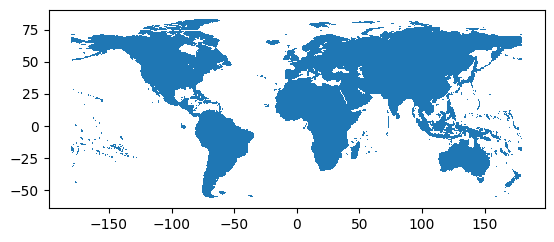

In [27]:
tiles.plot()

In [69]:
from shapely.geometry import box
import geopandas as gpd

# Define bounding boxes (approximate lat/lon ranges)
manhattan_bbox = (-74.01, 40.75, -73.86, 40.88)  # (min_lon, min_lat, max_lon, max_lat)

# Create polygons from bounding boxes
manhattan_polygon = box(*manhattan_bbox)  # Unpacks (minx, miny, maxx, maxy)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    {"borough": ["Manhattan"], "geometry": [manhattan_polygon]},
    crs="EPSG:4326"  # Latitude/Longitude (WGS84)
)

# Display the GeoDataFrame
print(gdf)

     borough                                           geometry
0  Manhattan  POLYGON ((-73.86 40.75, -73.86 40.88, -74.01 4...


<Axes: >

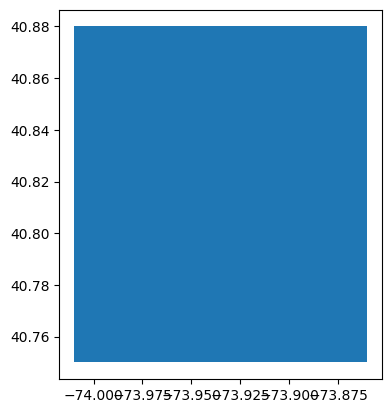

In [70]:
gdf.plot()

In [71]:
#find tiles that contain the target polygon
target_tiles=gp.sjoin(tiles, gdf)

In [66]:
target_tiles = tiles[tiles['tile'] == '301122200']
target_tiles

,tile,geometry


In [74]:
#download data from AWS S3
s3chmpath='forests/v1/alsgedi_global_v6_float/chm'
s3mskpath='forests/v1/alsgedi_global_v6_float/msk'
s3metapath='forests/v1/alsgedi_global_v6_float/metadata'
tifs=[]
metas=[]
for ii, row in target_tiles.iterrows():
    print(row.tile)

    #download chm
    s3file=f"{s3chmpath}/{row.tile}.tif"
    localfile=f"{localdir}/{os.path.basename(s3file)}"
    if not os.path.exists(localfile):
        s3_client.download_file(bucket, s3file, localfile)

    #also download cload masks
    # mskfile=f"{s3mskpath}/{row.tile}.tif.msk"
    # print(mskfile)
    # localmskfile=f"{localdir}/{os.path.basename(mskfile)}"
    # if not os.path.exists(localmskfile):
    #     s3_client.download_file(bucket, mskfile, localmskfile)

    #download metadata
    jsonfile=f"{s3metapath}/{row.tile}.geojson"
    localjsonfile=f"{localdir}/{os.path.basename(jsonfile)}"
    if not os.path.exists(localjsonfile):
        s3_client.download_file(bucket, jsonfile, localjsonfile)
    metas.append(localjsonfile)
        
    #apply mask
    outfile=localfile.replace('.tif', 'masked.tif')
    if not os.path.exists(outfile):
        enforce_mask(localfile, outfile)
    tifs.append(outfile)

032010110


In [12]:
#merge all tile tiffs into one continuous tif
mergefile=f"{localdir}/{os.path.basename(target_polyfile).replace('.geojson', '_alltiles.tif')}"
if not os.path.exists(mergefile):
    merge_rasters(tifs, outfile=mergefile)

In [13]:
#crop to bounds of input polygon
cropfile=mergefile.replace('_alltiles.tif', '_crop.tif')
if not os.path.exists(cropfile):
    crop_raster(mergefile, target_polyfile, cropfile)

In [84]:
meta = gpd.read_file("data/032010110.geojson")

# plot

In [87]:
meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 65536,
 'height': 65536,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'),
 'transform': Affine(1.1943285669558747, 0.0, -8296780.798186171,
        0.0, -1.1943285669558605, 5009377.08569731)}

In [ ]:
cropfile = f"{localdir}/032010110_cropped.tif"
with rasterio.open(cropfile) as src:
    data=src.read().squeeze()
    bounds=src.bounds
    width=src.width
    height=src.height
    meta=src.meta

In [ ]:
x = data[3000:3500, 3000:3500]

In [2]:
bbox = [-74.01, 40.75, -73.86, 40.88]

In [3]:
bbox_target = tuple(bbox)
bbox_target

(-74.01, 40.75, -73.86, 40.88)

In [5]:
from rasterio.warp import calculate_default_transform, reproject
from pyproj import CRS
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import shape, box
import os
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
import rioxarray as rxr


target_crs = 'EPSG:4326'


def filter_canopy_height(readfile, savefile):
    with rasterio.open(readfile) as src:
        source_crs = src.crs  # Get the source CRS of the TIFF file
        
    # Create a transformer to convert coordinates from target CRS to source CRS
    transformer = Transformer.from_crs(target_crs, source_crs, always_xy=True)
    
    # Transform the bounding box coordinates
    xmin_source, ymin_source = transformer.transform(bbox_target[0], bbox_target[1])
    xmax_source, ymax_source = transformer.transform(bbox_target[2], bbox_target[3])
    
    # Define the bounding box in the source CRS
    bbox_source = (xmin_source, ymin_source, xmax_source, ymax_source)
    

    # Step 1: Open the TIFF file using rioxarray
    rds = rxr.open_rasterio(readfile)
    rds_cropped = rds.rio.clip_box(*bbox_source)
    rds_reprojected = rds_cropped.rio.reproject(target_crs)

    # Step 4: Save the cropped and reprojected raster to a new file
    rds_reprojected.rio.to_raster(savefile)

In [6]:
with rasterio.open("data/032010110.tif") as src:
    crs = src.crs

In [6]:
filter_canopy_height("data/032010110.tif", "data/032010110_cropped.tif")

In [33]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

EPSG:4326


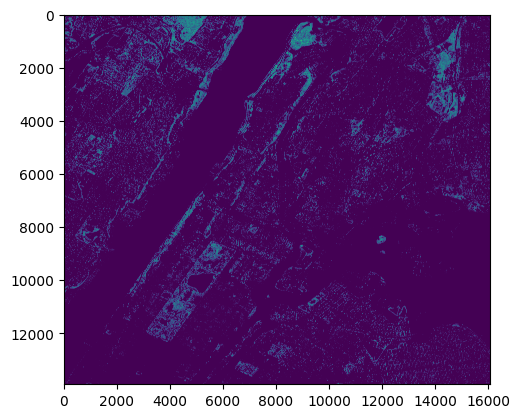

In [7]:
with rasterio.open("data/032010110_cropped.tif") as src:
    x = src.read(1)
    print(src.crs)
    
plt.imshow(x, cmap='viridis')

In [76]:
factor=10
new_width=int(width/10)
new_height=int(height/10)
xx = Image.fromarray(data).resize(
        (new_width, new_height), Image.BICUBIC
    )
chm=np.array(xx).astype('float')
#set nodata (with interp fuzziness)
chm[chm>200]=np.NaN

In [77]:
#a few functions for nice looking plots

def mercator_to_latlon_ax(ax, dec=2):
    xt=ax.get_xticks()
    yt=ax.get_yticks()
    trans = Transformer.from_proj("epsg:3857", "epsg:4326")
    #can do this because 3857 has parrallel lat and lon
    zlon=[yt[0] for _ in range(len(xt))]
    zlat=[xt[0] for _ in range(len(yt))]
    _,lon=trans.transform(xt, zlon)
    lat,_=trans.transform(zlat, yt)
    lons=[]
    for l in lon:
        if l<0:
            hem='W'
        else:
            hem='E'
        lons.append(f"{np.abs(np.round(l,dec))}{chr(176)}{hem}")
    lats=[]
    for l in lat:
        if l<0:
            hem='S'
        else:
            hem='N'
        lats.append(f"{np.abs(np.round(l,dec))}{chr(176)}{hem}")

    ax.set_yticklabels(lats, fontsize=18, fontweight="bold")
    ax.set_xticklabels(lons, fontsize=18, fontweight="bold")
    ax.yaxis.set_tick_params(rotation=90)

def geojson_to_poly(geojson):
    """
    Given a geojson with a polygon shape,
    return the shapely object
    """
    if len(geojson["features"]) > 1:
    	poly = GeometryCollection(
            [shape(feature["geometry"]).buffer(0) for feature in geojson["features"]]
        )
    else:
        f = geojson["features"][0]
        poly = shape(f["geometry"]).buffer(0)
    if poly.geom_type != "Polygon":
        pps = []
        for pp in poly.geoms:
            pp = polygon.orient(pp)  # correct winding
            pps.append(pp)
        out_geom = MultiPolygon(pps)
    else:
        out_geom = polygon.orient(poly)  # correct winding
    return out_geom

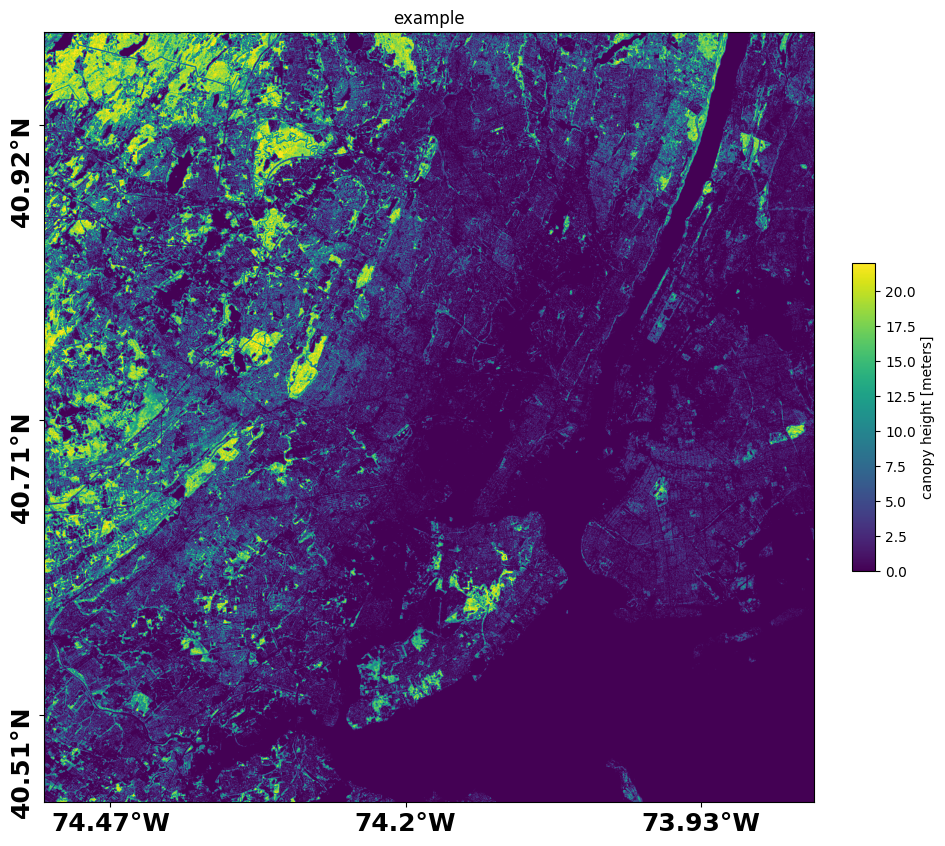

In [78]:
title='example'
fig, ax = plt.subplots(1, 1, figsize=[14, 10])
bbox=box(*bounds)
extent = (bbox.bounds[0], bbox.bounds[2], bbox.bounds[1], bbox.bounds[3])
colors=ax.imshow(chm, vmax=np.nanpercentile(chm,99.5), extent=extent)
tt = ax.get_xticks()[1:-1]
ax.set_xticks(tt[::3])
tt = ax.get_yticks()[1:-1]
ax.set_yticks(tt[::3])
mercator_to_latlon_ax(ax, dec=2)
cax = plt.gca().inset_axes([1.05, 0.3, 0.03, 0.4])
plt.colorbar(colors, cax=cax, label='canopy height [meters]')
ax.set_title(title)
plt.savefig(f'data/{title}.png', dpi=300)

# plot observation dates

In [79]:
all_polys=[]
for ff in metas:
    gdf=gp.read_file(ff)
    all_polys.append(gp.overlay(gdf, target_tiles))
meta_gdf=pd.concat(all_polys)

TypeError: Image data of dtype datetime64[ms] cannot be converted to float

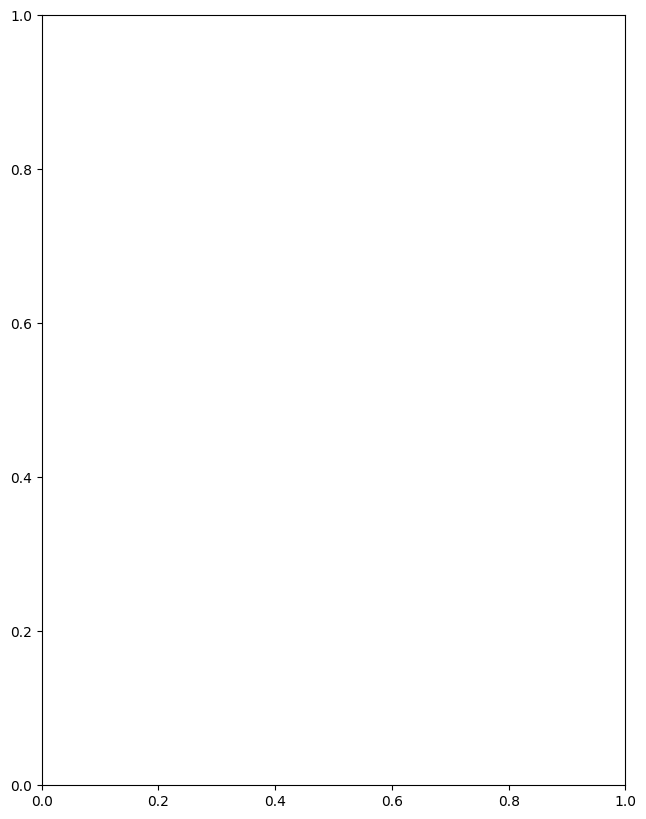

In [80]:
fig, ax = plt.subplots(1, 1, figsize=[14, 10])
meta_gdf.plot(ax=ax, column="acq_date", cmap='viridis', legend=True)
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')
ax.spines[['right', 'top']].set_visible(False)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 0., 0.2, 0.2))
plt.savefig(f'data/{title}_obsdate.png', dpi=300)

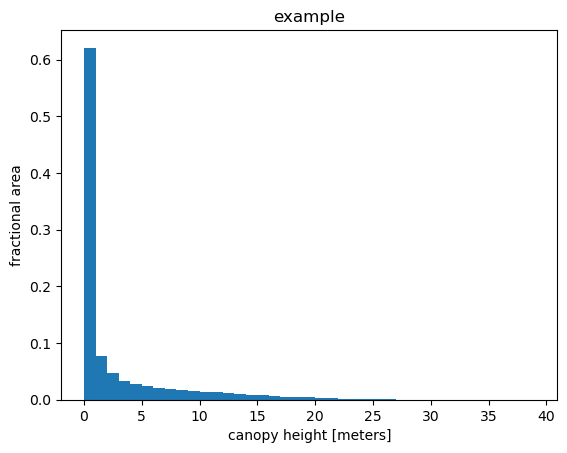

In [21]:
#histogram of canopy height across area
chm_flat=chm.flatten()
bins=np.arange(0,40)
plt.hist(chm_flat, bins=bins, weights=np.ones(len(chm_flat)) / len(chm_flat))
plt.xlabel('canopy height [meters]')
plt.ylabel('fractional area')
plt.title(title)
plt.savefig(f'data/{title}_hist.png', dpi=300)